In [1]:
import numpy as np
from t_test_cpd import TTestCPDetector
import os
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
import json
import torch
import random
from cpd_evaluation import binary_evaluation, add_evaluation, nab_evaluation
from agent import DoubleDQNAgent
from world_cup_env import WorldCupEnv
from agent import DoubleDQNAgent
from train_utils import OffPolicyTrainer


import matplotlib
font = {'size': 16}

matplotlib.rc('font', **font)

In [2]:
DATASET_PATH = "signal"
AGENT_STATE_DICT="rl_weight"
N_LOOKBACK = 4
N_PREDICT = 2

DEVICE="cuda" if torch.cuda.is_available() else "cpu"
EVAL_RESULT_PATH="eval_rlcpd"

In [3]:
def get_data_file_list(dataset_path: str) -> List[str]:
    return os.listdir(dataset_path)

In [4]:
def read_dataset(csv_path: str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path)
    return df["signal"].to_numpy(), df["is_change_point"].to_numpy(dtype=np.int32)

eval results: reward -50.000000


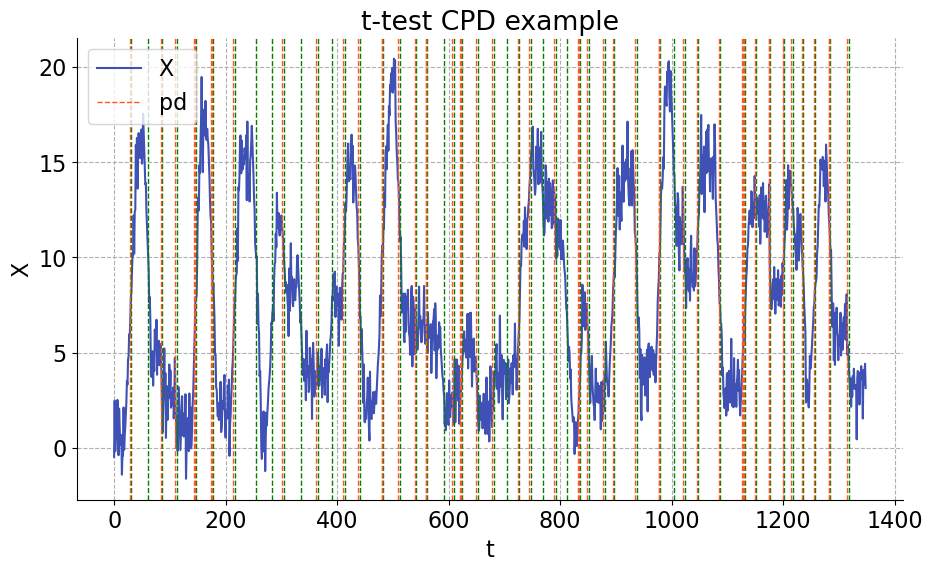

eval results: reward -39.000000


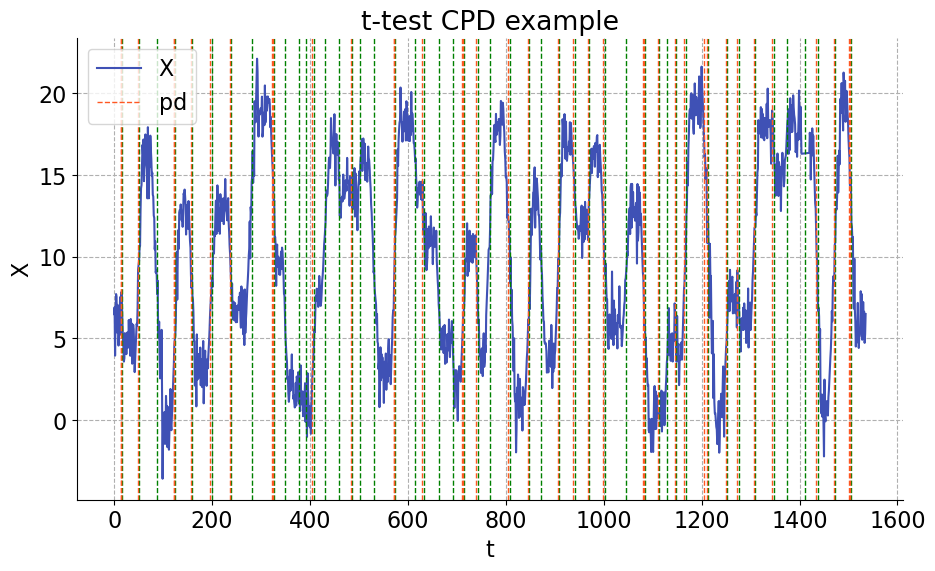

eval results: reward -25.000000


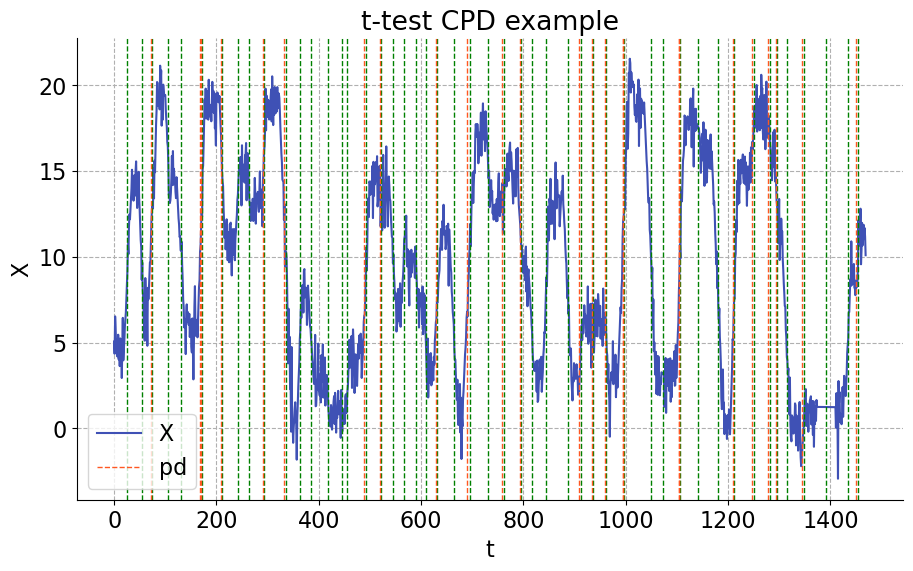

eval results: reward -62.000000


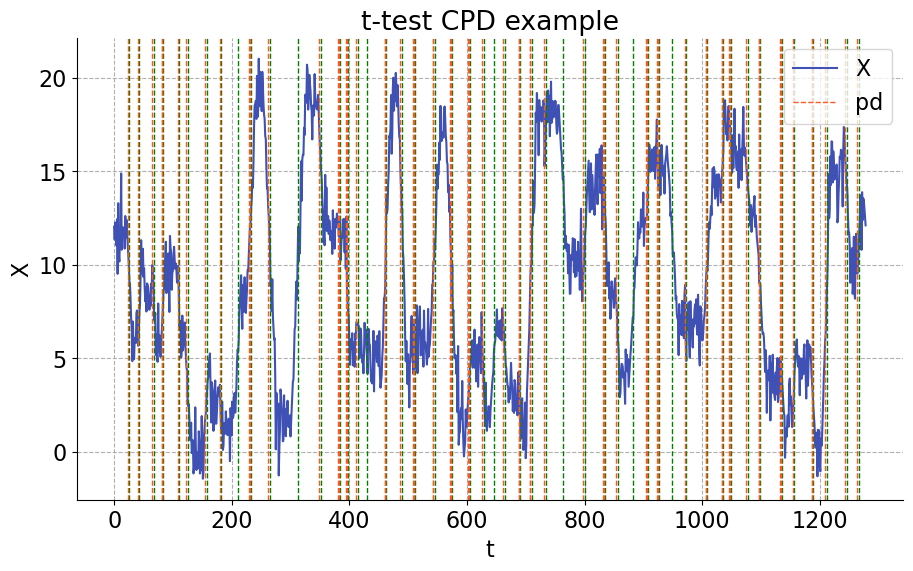

eval results: reward -56.000000


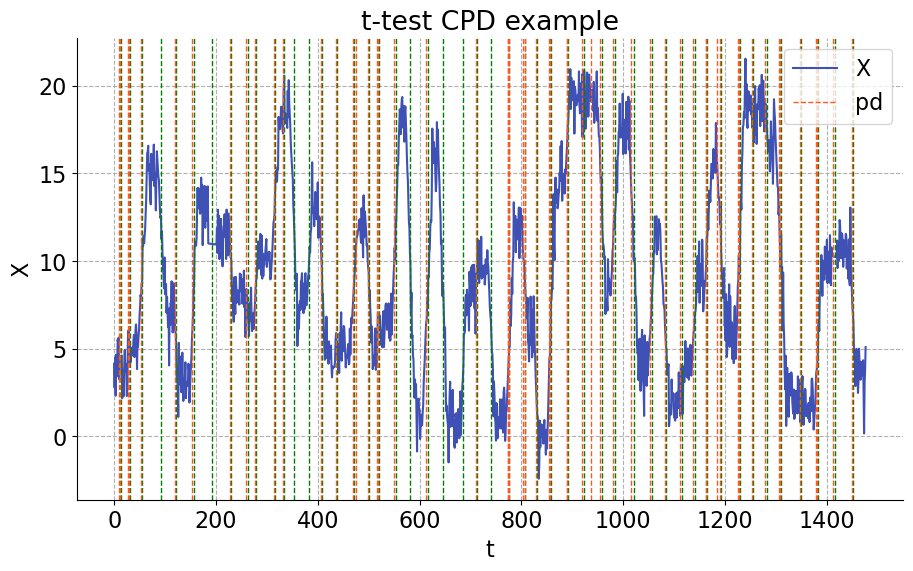

eval results: reward -57.000000


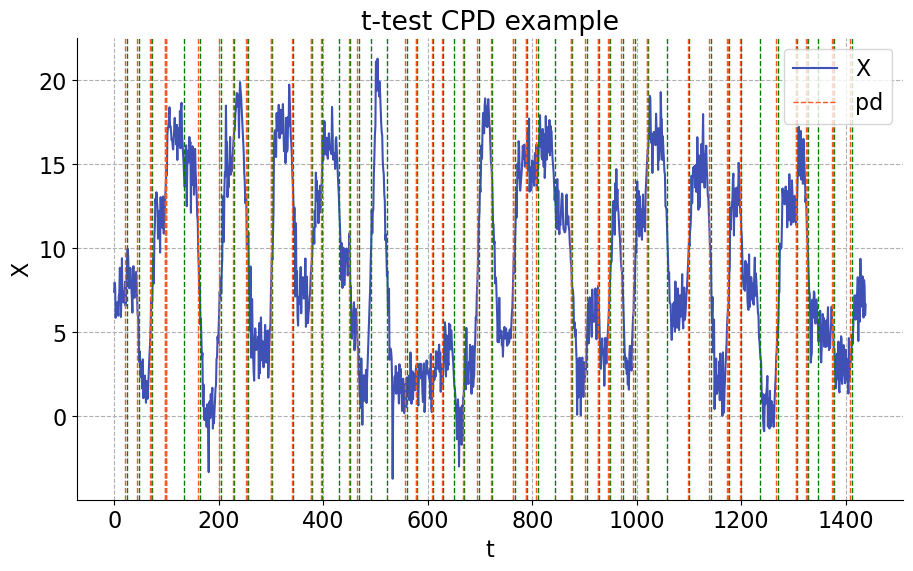

eval results: reward -61.000000


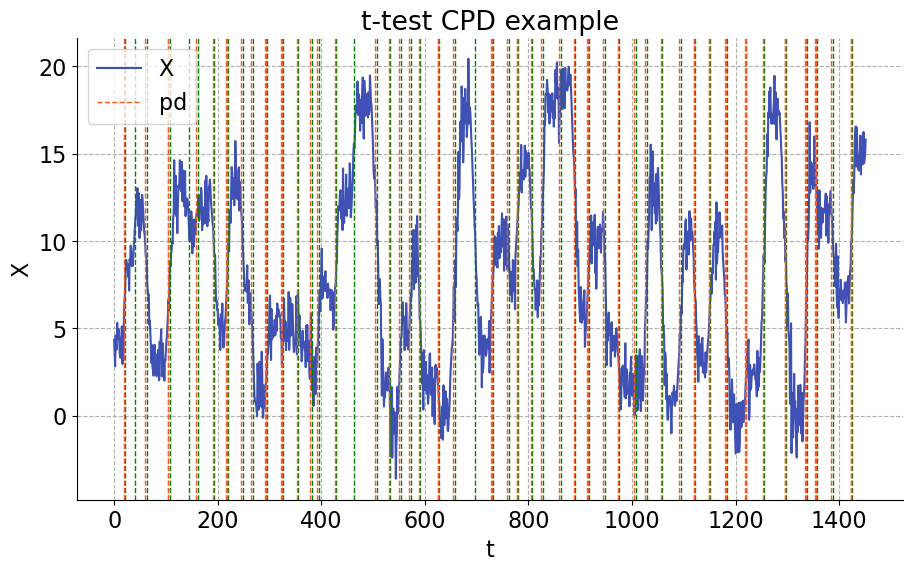

eval results: reward -57.000000


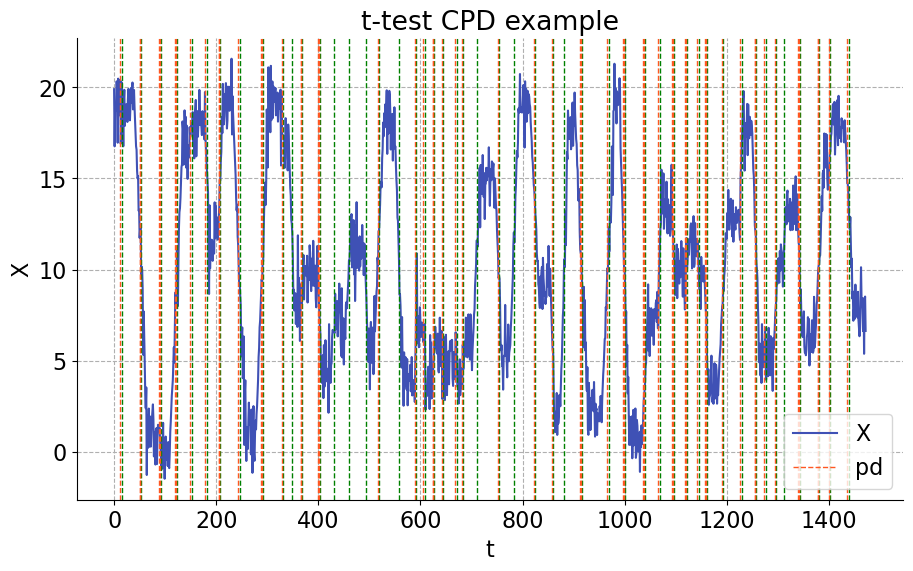

eval results: reward -52.000000


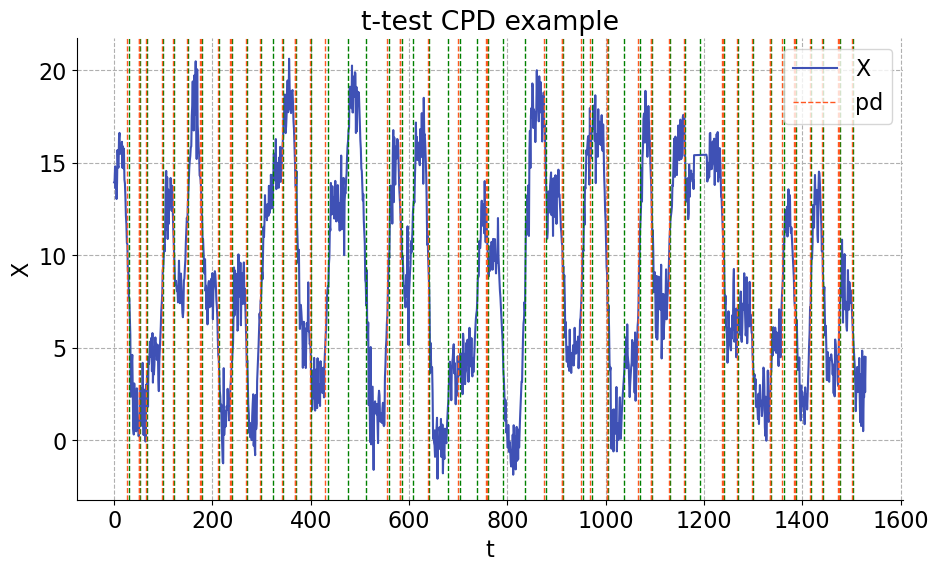

eval results: reward -52.000000


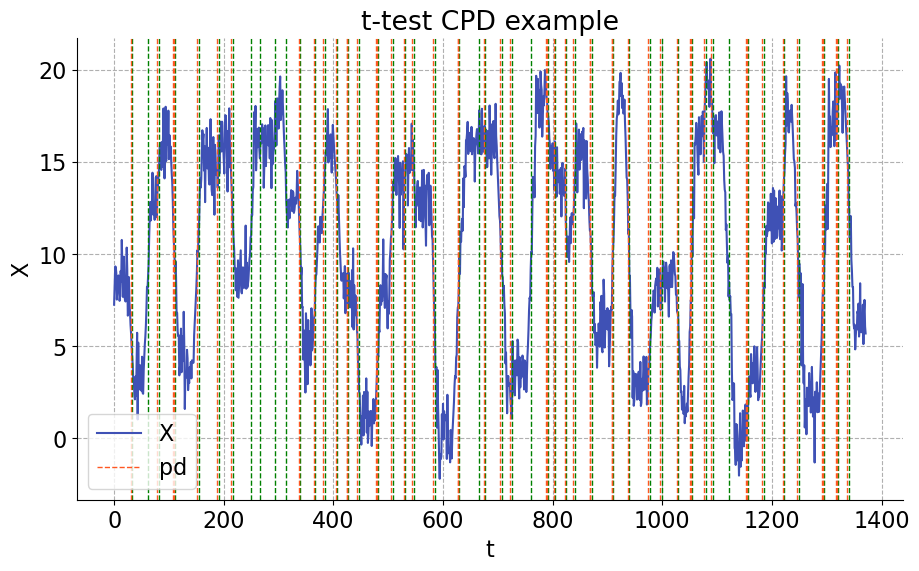

In [5]:
precision_dict = {}
recall_dict = {}
f1_dict = {}
missing_rate_dict = {}
add_dict = {}
nab_dict = {}
for file_name in get_data_file_list(DATASET_PATH):
    signal, is_change_point = read_dataset(os.path.join(DATASET_PATH, file_name))
    agent = DoubleDQNAgent(2)
    agent.load(os.path.join(AGENT_STATE_DICT,file_name.split(".")[0]+".pth"))
    signal = signal/10.0
    workload_diff = np.diff(signal).reshape((-1, 1))
    env = WorldCupEnv(workload_diff, is_change_point, N_LOOKBACK, N_PREDICT)
    trainer = OffPolicyTrainer(env, agent, num_episodes=150, replay_buffer_size=128, batch_size=32, discount_factor=0.9, epsilon_start=0.5, epsilon_end=0.1, epsilon_step=20, learning_rate_start=1e-3, learning_rate_end=1e-4, learning_rate_step=100, tau=0.05)
    trainer.set_env(env)
    state_list, action_list = trainer.eval()
    signal = signal*10.0
    is_cpd_near_idx = np.where(np.array(action_list) == 1)[0]+N_LOOKBACK
    fig, ax = plt.subplots()
    fig.set_size_inches(16/1.5, 6)
    ax.plot(np.arange(len(signal)), signal, label='X', color="#3F51B5")
    for gt in np.where(is_change_point)[0]:
        plt.axvline(x=gt, color='green', linestyle='--', linewidth=1)
    cpd_line = None
    for cp in is_cpd_near_idx:
        cpd_line = ax.axvline(x=cp, linestyle='--', linewidth=1, color="#FF5722")
    cpd_line.set_label("pd")
    ax.set_xlabel('t')
    ax.set_ylabel('X')
    ax.set_title("t-test CPD example")
    ax.legend()
    ax.grid(True, linestyle="--")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    pd_change_onehot = [0]*len(signal)
    for cp in is_cpd_near_idx:
        pd_change_onehot[cp] = 1
    pd_change_onehot = np.array(pd_change_onehot, dtype=np.int32)
    
    precision, recall, f1, missing_rate = binary_evaluation(is_change_point, pd_change_onehot,8)
    add, _ = add_evaluation(is_change_point, pd_change_onehot, 8)
    nab = nab_evaluation(is_change_point, pd_change_onehot, 8)

    file_name = file_name.split(".")[0]
    precision_dict[file_name] = precision
    recall_dict[file_name] = recall
    f1_dict[file_name] = f1
    missing_rate_dict[file_name] = missing_rate
    add_dict[file_name] = add
    nab_dict[file_name] = nab
    
if not os.path.exists(EVAL_RESULT_PATH):
    os.makedirs(EVAL_RESULT_PATH)
df_dict = {}
df_dict["signal_name"] = list(precision_dict.keys())
df_dict["precision"] = list(precision_dict.values())
df_dict["recall"] = list(recall_dict.values())
df_dict["f1"] = list(f1_dict.values())
df_dict["missing_rate"] = list(missing_rate_dict.values())
df_dict["add"] = list(add_dict.values())
df_dict["nab"] = list(nab_dict.values())
pd.DataFrame.from_dict(df_dict).to_csv(os.path.join(EVAL_RESULT_PATH,"eval.csv"),index=False)